In [1]:
from sys import path
path.append('/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/')

import math
import fileinput
import sys
import os
import numpy as np
from scipy.stats.stats import pearsonr
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
import timeit
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve
from sklearn.metrics import make_scorer
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, chi2
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

In [2]:
def replaceAll(file,searchExp,replaceExp):
    for line in fileinput.input(file, inplace=1):
        if searchExp in line:
            line = line.replace(searchExp,replaceExp)
        sys.stdout.write(line)

def convert(value):
    try:
        return float(value)
    except ValueError:
        return value

def column(matrix, i):
    return [map(convert,row.split())[i] for row in matrix]

def intersect(a, b):
    return list(set(a) & set(b))

def partial_shuffle(lst, imin, imax):
    lst[imin:imax] = sorted(lst[imin:imax], key=lambda x: random.random())
    return lst


In [3]:
def readSDSS(filename,column):
# read and save columns from fits file
    start = timeit.default_timer()
    bigstuff = fits.open(filename,ignore_missing_end='True')
    bigdata = bigstuff[1]
    return bigdata.data.field(column)
    stop = timeit.default_timer()
    print 'Time to read SDSS dataset:', - start + stop
    os.system('say "done reading"')
    bigstuff.close()

def writeSDSS(filename,vars):
    file = open(filename,'w')
    for i in range(vars.shape[0]):
        line = "\t".join(map(str, vars[i,:]))
        file.write(line + '\n')
    file.close()
    os.system('say "done writing"')

In [4]:
def readmets(metfile = 'gal_fiboh_dr7_v5_2.fits'):
    
    # read metallicities #

    stuff = fits.open(metfile)

    data = stuff[1].data

    mets = data.field(0)

    stuff.close()
    
    return mets


def readinfo(infofile = 'gal_info_dr7_v5_2.fit'):

    # read redshifts #

    file = fits.open(infofile)

    info = file[1].data

    red = info.field('Z').clip(0) #get rid of -inf, negatives

    red_err = info.field('Z_ERR').clip(0) #get rid of -inf, negatives

    red_warn = info.field('Z_WARNING')

    subclass = info.field('SUBCLASS')
    
    spectrotype = info.field('SPECTROTYPE')

    ebv = info.field('E_BV_SFD')

    ebvcoeff = [5.155,3.793,2.751,2.086,1.479] #from Schlegel 1998
    
    return red, red_err, red_warn, spectrotype, subclass, ebv, ebvcoeff


def readelines(elinesfile='gal_line_dr7_v5_2.fit'):

# read emission line fluxes #

    stuff = fits.open(elinesfile)

    data = stuff[1].data

    OII_I = data.field('OII_3726_FLUX')

    OII_II = data.field('OII_3729_FLUX')

    OII = OII_I + OII_II

    OIII_I = data.field('OIII_4959_FLUX')

    OIII_II = data.field('OIII_5007_FLUX')

    OIII = OIII_I + OIII_II

    NII_I = data.field('NII_6548_FLUX')
    
    NII_II = data.field('NII_6584_FLUX')
    
    NII = NII_I + NII_II

    Halpha = data.field('H_ALPHA_FLUX')

    Hbeta = data.field('H_BETA_FLUX')

    stuff.close()
    
    return OII, OIII, NII, Halpha, Hbeta


# Kauffamn03 log([OIII]/Hb) = 0.61 / (log([NII]/Ha) - 0.05) + 1.3

def readmass(massfile='totlgm_dr7_v5_2.fit'):

# read masses #

    file = fits.open(massfile)

    info = file[1].data

    mass = info.field('MEDIAN').clip(0) #get rid of -inf, neg values
    
    mass_16 = info.field('P16').clip(0) #get rid of -inf 
    
    mass_84 = info.field('P84').clip(0) #get rid of -inf 
    
    return mass, mass_16, mass_84

def readmags(magfile='SDSS_modmags.txt',errmagfile='SDSS_errmodmags.txt',correctdust=True):

# read magnitudes and uncertainties, correct for dust if needed

    mags = np.loadtxt(magfile)
    
    errmags = np.loadtxt(errmagfile)
    
    return mags, errmags
    
    if (correctdust):
    
        for i in range(len(mags[1])):

            mags[:,i] = mags[:,i] - ebv[:]*ebvcoeff[i]

#Note: missing values (-9999.0) replaced with 0.05

    

In [5]:
def FeatureRanking(labels,X_train,y_train,X_test,y_test,estimator = RandomForestRegressor(n_estimators=10),plot=False,plottitle='Feature importances',color='b',nmax = 0):

# Feature selection most helpful link

# http://scikit-learn.org/stable/modules/feature_selection.html

    estimator.fit(X_train, y_train)

    importances = estimator.feature_importances_

    indices = np.argsort(importances)[::-1]

    print 'Indices', len(indices)

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(len(indices)):

        print("%d. feature %d %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

    if plot:    
        if nmax != 0:
            maxind = nmax
            aspect = min(20, int(30*float(maxind)/float(len(indices))))
        else:
            maxind = len(indices)
            aspect = 20
        print aspect
    # Plot the feature importances
        fig = plt.figure(figsize=(aspect,6))        
        rcParams.update({'font.size': 18})
        ax = plt.subplot(111)
        ax.set_title(plottitle)
        ax.bar(range(maxind), importances[indices[:maxind]],
            color=color, align="center")
        ax.set_xticks(range(maxind))
        ax.set_xticklabels(labels[indices[:maxind]],rotation=45, rotation_mode="anchor", ha="right")
        ax.set_xlim([-1, maxind])
        plt.tight_layout()
#        plt.savefig(plottitle+'.pdf')
        plt.show()
    
    return indices

In [6]:
def PerformanceFeatures(totalfeatures,indices,labels,X_train,y_train,X_test,y_test,ylim=None,estimator = RandomForestRegressor(n_estimators=10),plottitle='Performance'):
    R2SCORE = []
    resscat = [] 
    OLF = []
    for i in range(1,totalfeatures+1):
        estimator.fit(X_train[:,indices[:i]],y_train)
        y_pred, olf, rmse, rmsenool, r2 = prediction(X_train[:,indices[:i]], y_train, X_test[:,indices[:i]],y_test,estimator)
        R2SCORE.append(r2)
        OLF.append(olf)
        resscat.append(np.std(y_pred - y_test))
        
    rcParams.update({'font.size': 16})
    plt.semilogy(range(1,totalfeatures+1),R2SCORE, '-', label = 'r2 score')
    plt.semilogy(range(1,totalfeatures+1),OLF, '--', label = 'OLF')   
    plt.semilogy(range(1,totalfeatures+1),resscat,':', label = 'RMSE')    
    if ylim == None:
        axes = plt.gca()
        axes.set_ylim([0.01,50])
    
    plt.xlim([0,totalfeatures])
    plt.tight_layout()
    plt.xlabel('Number of features in use')
    plt.legend(frameon=False,loc = 'best')
#    plt.savefig(plottitle+'.pdf')
    plt.show()

    return 


def buildsample(allmags,set,addmass,red,mass = None,bands = ['u','g','r','i','z'],elinesfluxes=None,elineslabels=[]):

#--- define ugriz magnitudes and add redshift column ---#

    nbands = allmags.shape[1]

    ncolors = nbands*(nbands-1)/2

    nsquaredcolors = nbands*(nbands-1)/2
    
    nelines = len(elineslabels)

    if addmass:
        masvar = 1
    else:
        masvar = 0

    resampling = False

# SET 1: MAGS, COLORS, RED

# SET 2: MAGS, COLORS, COLORSSQ, RED

    if set == 1:
    
        dataset = np.zeros([allmags.shape[0],nbands+ncolors+1+masvar+nelines]) #mags, colors, redshift
    
        labels = np.chararray((nbands+ncolors+1+masvar+nelines),itemsize=12)

    elif set == 2:
    
        dataset = np.zeros([allmags.shape[0],nbands+ncolors+nsquaredcolors+1+masvar+nelines]) #mags, colors, squared colors, redshift
    
        labels = np.chararray((nbands+ncolors+nsquaredcolors+1+masvar+nelines),itemsize=12)

    else:
    
        stop


    count = 0

    for i in range(nbands): # cycle through bands
    
        dataset[:,i] = allmags[:,i] # let's start from magnitudes
        labels[count] = bands[i]
        count+=1

    for i in range(nbands): # cycle through bands
    
        for j in range(0,i): #all possible permutations of colors
        
        #            print i,j,count, labels[i]+'-'+labels[j]+' color'
        
            dataset[:,count] = allmags[:,i]-allmags[:,j] #colors
        
            labels[count] = labels[i]+' - '+labels[j]
        
            count+=1
        
            if set == 2:
            
                dataset[:,count] = (allmags[:,i]-allmags[:,j])**2
            
                labels[count] = '('+labels[i]+' - '+labels[j]+')$^2$'
            
                count+=1
                
    for i in range (nelines):

        dataset[:,count] = elinesfluxes[:,i]

        labels[count] = elineslabels[i]

        count +=1

    if (addmass):
    
        dataset[:,-2] = mass 
    
        dataset[:,-1] = red
    
        labels[-2] = 'Mass'
    
        labels[-1] = 'Redshift'

    else:
    
        dataset[:,-1] = red
        
        labels[-1] = 'Redshift'
        
    return dataset, labels


def prediction(X_train,y_train,X_test,y_test,clf,resampling=False,olthreshold=0.2,printout=False):

    y_pred = clf.fit(X_train, y_train).predict(X_test)
    
    noolpred = np.ma.compressed(np.ma.masked_where(abs(y_pred-y_test) > olthreshold, y_pred))
    nooltest = np.ma.compressed(np.ma.masked_where(abs(y_pred-y_test) > olthreshold, y_test))

    if printout:
    
        print 'r^2 Score =', r2_score(y_test, y_pred)

        print 'Mean and median absolute deviation', np.mean(abs(y_pred - y_test)), np.median(abs(y_pred - y_test))

        print 'Scatter of residuals', np.std(y_pred - y_test)
        
        print 'RMSE', np.sqrt(np.mean(((y_pred) - (y_test))**2))
    
        print 'Outlier fraction', 1-float(len(noolpred))/float(len(y_test))
        
        print 'Excluding outliers:'

        print 'RMSE', np.sqrt(np.mean(((noolpred) - (nooltest))**2))
    
    return y_pred, 1-float(len(noolpred))/float(len(y_test)), np.sqrt(np.mean(((y_pred) - (y_test))**2)), np.sqrt(np.mean(((noolpred) - (nooltest))**2)), r2_score(nooltest, noolpred)


In [7]:
#select data

def makedataset(test, mets, mags, err_mags, red, err_red, bands = ['u','g','r','i','z'], mass = [], err_mass = [], subclass = [], spectrotype = [], elines = [], elineslabels = [], minred = 0.0, maxred = 1.0, find = None): 

    if test == 1:
        minred = 0.09
        maxred = 0.12
        find = np.where(np.logical_and(mass > 0., np.logical_and(spectrotype == 'GALAXY', np.logical_and(subclass != 'AGN',np.logical_and(mags[:,2] < 18.0, np.logical_and(red > minred,np.logical_and(red < maxred,np.logical_and(np.logical_and(mets > 0.0, red_warn == 0), np.all(abs(mags[:,0:mags.shape[1]]) > 0.01, axis = 1)))))))))
    elif test == 2:
        minred = 0.2
        maxred = 0.25
        find = np.where(np.logical_and(mass > 0., np.logical_and(spectrotype == 'GALAXY', np.logical_and(subclass != 'AGN',np.logical_and(mags[:,2] < 25, np.logical_and(red > minred,np.logical_and(red < maxred,np.logical_and(np.logical_and(mets > 0.0, red_warn == 0), np.all(mags[:,0:mags.shape[1]] > 0.01, axis = 1)))))))))
    elif bool(len(find)) == False: 
        minred = minred
        maxred = maxred
        find = np.where(np.logical_and(mets > 0.0, mass > 0.0))
    
    print 'Creating data set with', len(find[0]), 'objects'
    
    useelines = bool(len(elines))
    
    addmass = bool(len(mass))
    
    if useelines:

        elinesfluxes = np.column_stack(elines)
                        
    else:
                        
        elinesfluxes = np.zeros([mags.shape[0],mags.shape[1]])

# Also calculate uncertainties for magnitudes, redshift and mass if used

    imp = Imputer(missing_values=0, strategy='median', axis=0)

    imp.fit(err_mags)

    err_mags = imp.transform(err_mags)

    imp = Imputer(missing_values=0, strategy='median', axis=1) #1D array; for mass and redshift
    
    err_red = imp.fit_transform(err_red)
    
    if addmass:
        
        err_mass = imp.fit_transform(err_mass)
                        
    else:
    
        mass = np.ones(mags.shape[0]) #adding two mock vectors; made of ones so we don't mess with Imputer
        
        err_mass = np.ones(mags.shape[0])
                        
    X, y, z, m, e, z_e, m_e, l = mags[find[0],:],mets[find[0]],red[find[0]],mass[find[0]],err_mags[find[0],:], err_red.T[find[0]], err_mass.T[find[0]], elinesfluxes[find[0],:] #from sklearn utils, not random 
    
    return X, y, z, m, e, z_e, m_e, l, elineslabels, bands
 

In [8]:
def build_train_test(X, y, z, m, e, l, elineslabels, bands, set = 2, traintestsplit = .2, scaling = False):

    addmass = bool(np.std(m) > 0.01)
    
    nsamples = X.shape[0]

    percentile = int(nsamples*traintestsplit)
    
    #shuffle#
    
    X, y, z, m, e, l = shuffle(X, y, z, m, e, l)
    
    if bool(len(l)): 
        
        X_train, trainlabels = buildsample(X[percentile:,:],set,addmass,z[percentile:],mass=m[percentile:],bands = bands, elinesfluxes = l[percentile:],elineslabels=elineslabels)
   
        X_test, testlabels = buildsample(X[:percentile,:],set,addmass,z[:percentile],mass=m[:percentile],bands = bands, elinesfluxes=l[:percentile],elineslabels=elineslabels)
    
    else:
        
        X_train, trainlabels = buildsample(X[percentile:,:],set,addmass,z[percentile:],mass=m[percentile:], bands = bands)
   
        X_test, testlabels = buildsample(X[:percentile,:],set,addmass,z[:percentile],mass=m[:percentile], bands = bands)
        
    y_train, y_test = y[percentile:], y[:percentile]
    
    if scaling:
        
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
    return X_train, y_train, X_test, y_test, trainlabels

In [9]:
def my_loss_func(pred, truth):
    return np.std(pred - truth) #scatter of residuals

loss  = make_scorer(my_loss_func, greater_is_better=False)

In [10]:
def predict_with_cv(X, y, z, m, e, l, elineslabels, bands, clf,olthreshold=0.2,cv=10,scaling=False):
    RMSE = []
    RMSENOOL = []
    OLF = []
    R2_SCORE = []
    print 'Progress...'
    for i in range(cv):
        X_train, y_train, X_test, y_test, labels = build_train_test(X, y, z, m, e, l, elineslabels, bands, scaling = scaling)
        print 'CV ', str(i), '...'
        y_pred, olf, rmse, rmsenool, r2 = prediction(X_train,y_train,X_test,y_test,clf,olthreshold=olthreshold) 
        RMSE.append(rmse)
        RMSENOOL.append(rmsenool)
        OLF.append(olf)
        R2_SCORE.append(r2)
    print 'Average OLF/RMSE/RMSE with no OL/r2 score', np.mean(OLF), 'pm', np.std(OLF), np.mean(RMSE), 'pm', np.std(RMSE), np.mean(RMSENOOL), 'pm', np.std(RMSENOOL), np.mean(R2_SCORE), 'pm', np.std(R2_SCORE)
    return y_pred, np.mean(OLF), np.mean(RMSE), np.mean(RMSENOOL), np.mean(R2_SCORE)

In [43]:
def plot_multi_learning_curve(estimator, title, X, y, ylim = None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 6), scoring = 'mean_squared_error'):
    
    
    plt.title(title)
#    if ylim != None:
#        plt.set_ylim(*ylim)
    plt.xlabel("Fraction of training examples")
    plt.ylabel("RMSE")
    train_sizes_pct = train_sizes
    colors = ["b","g"]

    for j, a in enumerate(zip(X,y)):
        dummy, train_scores, test_scores = learning_curve(
        estimator[j], a[0], a[1], cv=cv, n_jobs=2, train_sizes=train_sizes, scoring = scoring)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        print - test_scores_mean, test_scores_std
        plt.grid()

        plt.fill_between(train_sizes_pct, -test_scores_mean - test_scores_std,
                     -test_scores_mean + test_scores_std, alpha=0.1, color=colors[j])

        plt.plot(train_sizes_pct, - test_scores_mean, 'o-', color=colors[j],
                 label="Test set"+str(j+1))

        plt.fill_between(train_sizes_pct, -test_scores_mean - test_scores_std,
                     -test_scores_mean + test_scores_std, alpha=0.1, color=colors[j])

    plt.legend(loc="best",frameon=False)
    plt.tight_layout()
    if ylim != None:
        axes = plt.gca()
        axes.set_ylim(*ylim)
#    plt.savefig(title+'.pdf')
    return plt

In [12]:
def calculate_uncertainties(X, y, z, m, e, l, red_err, mass_err, clf, ntrials = 50, traintestsplit = 0.2, set = 2):
    
    X, y, z, m, e, l, red_err, mass_err = shuffle(X, y, z, m, e, l, red_err, mass_err)
    
    addmass = bool(np.std(m))
    
    nsamples = X.shape[0]

    percentile = int(nsamples*traintestsplit)
    
    metallicities = np.zeros([ntrials,percentile])

    for j in range(ntrials):
        
        newmags = np.array([np.random.normal(X[:,i], e[:,i]) for i in range(X[1].shape[0])])
    
        newmags = newmags.T
        
        z = [np.random.normal(a,b) for a,b in zip(z, red_err)]
        
        if addmass:
            
            m = [np.random.normal(a,b) for a,b in zip(m, mass_err)]
        
        X_train, trainlabels = buildsample(newmags[percentile:,:],set,addmass,z[percentile:],m[percentile:])
   
        X_test, testlabels = buildsample(newmags[:percentile,:],set,addmass,z[:percentile],m[:percentile])

        y_train, y_test = y[percentile:], y[:percentile]
        
        metallicities[j,:], olf, rmse, rmsenool, r2 = prediction(X_train,y_train,X_test,y_test,clf,olthreshold=0.2)
    
    print 'Average scatter', np.mean(np.std(metallicities,axis=0))
    
    return np.mean(np.std(metallicities,axis=0)), metallicities

In [13]:
#Let's read in some variables

mets = readmets()
red, red_err, red_warn, spectrotype, subclass, ebv, ebvcoeff = readinfo()
mass, mass_lo, mass_hi = readmass()
OII, OIII, NII, Halpha, Hbeta = readelines()
mags, errmags = readmags(correctdust=True) #this takes about a minute

In [14]:
indexes_sanders = map(int,np.loadtxt('SandersIndexes.txt'))

In [15]:
# Let's build sample data set 1 and check that everything works.

X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(1, mets, mags, errmags, red, red_err, mass = mass, err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass)
X_train, y_train, X_test, y_test, labels = build_train_test(X, y, z, m, e, l, elineslabels, bands, traintestsplit=.2)
prediction(X_train, y_train, X_test, y_test,linear_model.RidgeCV(),olthreshold=0.2,printout=True)   


Creating data set with 25316 objects
r^2 Score = 0.444698306987
Mean and median absolute deviation 0.0628938928272 0.0494568765771
Scatter of residuals 0.0857775568042
RMSE 0.0857790040781
Outlier fraction 0.0270590558957
Excluding outliers:
RMSE 0.0704560127557


(array([ 8.98938465,  8.93711949,  9.0098944 , ...,  8.95856683,
         9.06221329,  9.0805273 ]),
 0.027059055895714,
 0.085779004078063173,
 0.070456012755727951,
 0.55115237521453109)

In [455]:
#optimizing ET regressor
parameters = {'n_estimators':[10, 50, 100], 'min_samples_split':[2, 4, 6,8], 'min_samples_leaf':[2,4,6,8]}
ncv=3
clf = GridSearchCV(ExtraTreesRegressor(),parameters,cv=ncv,scoring = loss,verbose=2)
clf.fit(X_train,y_train)

ETbest = clf.best_estimator_
ETbestscore = clf.best_score_

print ETbest, ETbestscore

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] min_samples_split=2, n_estimators=10, min_samples_leaf=2 ........
[CV]  min_samples_split=2, n_estimators=10, min_samples_leaf=2 -   0.9s
[CV] min_samples_split=2, n_estimators=10, min_samples_leaf=2 ........
[CV]  min_samples_split=2, n_estimators=10, min_samples_leaf=2 -   0.9s
[CV] min_samples_split=2, n_estimators=10, min_samples_leaf=2 ........
[CV]  min_samples_split=2, n_estimators=10, min_samples_leaf=2 -   0.9s
[CV] min_samples_split=2, n_estimators=50, min_samples_leaf=2 ........
[CV]  min_samples_split=2, n_estimators=50, min_samples_leaf=2 -   4.7s
[CV] min_samples_split=2, n_estimators=50, min_samples_leaf=2 ........
[CV]  min_samples_split=2, n_estimators=50, min_samples_leaf=2 -   4.5s
[CV] min_samples_split=2, n_estimators=50, min_samples_leaf=2 ........
[CV]  min_samples_split=2, n_estimators=50, min_samples_leaf=2 -   4.2s
[CV] min_samples_split=2, n_estimators=100, min_samples_leaf=2 .......
[CV]  min

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:  2.9min



[CV] min_samples_split=2, n_estimators=50, min_samples_leaf=4 ........
[CV]  min_samples_split=2, n_estimators=50, min_samples_leaf=4 -   3.1s
[CV] min_samples_split=2, n_estimators=100, min_samples_leaf=4 .......
[CV]  min_samples_split=2, n_estimators=100, min_samples_leaf=4 -   6.7s
[CV] min_samples_split=2, n_estimators=100, min_samples_leaf=4 .......
[CV]  min_samples_split=2, n_estimators=100, min_samples_leaf=4 -   6.9s
[CV] min_samples_split=2, n_estimators=100, min_samples_leaf=4 .......
[CV]  min_samples_split=2, n_estimators=100, min_samples_leaf=4 -   6.4s
[CV] min_samples_split=4, n_estimators=10, min_samples_leaf=4 ........
[CV]  min_samples_split=4, n_estimators=10, min_samples_leaf=4 -   0.7s
[CV] min_samples_split=4, n_estimators=10, min_samples_leaf=4 ........
[CV]  min_samples_split=4, n_estimators=10, min_samples_leaf=4 -   0.6s
[CV] min_samples_split=4, n_estimators=10, min_samples_leaf=4 ........
[CV]  min_samples_split=4, n_estimators=10, min_samples_leaf=4 -   

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  7.8min finished


In [64]:
#Export data for test set 2
a = np.column_stack((z,y,m)) #red, mass, mets
np.savetxt('SDSS_ts2_input.txt',a, fmt='%.6f', delimiter='\t', newline='\n')

In [456]:
#optimizing Random Forest Regressor

parameters = {'n_estimators':[10, 20, 40], 'min_samples_split':[2, 4, 6,8], 'min_samples_leaf':[2,4,6,8]}
clf = GridSearchCV(RandomForestRegressor(),parameters,cv=ncv,scoring = loss,verbose=2)
clf.fit(X_train,y_train)

RFbest = clf.best_estimator_
RFbestscore = clf.best_score_

print RFbest, RFbestscore

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] min_samples_split=2, n_estimators=10, min_samples_leaf=2 ........
[CV]  min_samples_split=2, n_estimators=10, min_samples_leaf=2 -   4.3s
[CV] min_samples_split=2, n_estimators=10, min_samples_leaf=2 ........
[CV]  min_samples_split=2, n_estimators=10, min_samples_leaf=2 -   4.2s
[CV] min_samples_split=2, n_estimators=10, min_samples_leaf=2 ........
[CV]  min_samples_split=2, n_estimators=10, min_samples_leaf=2 -   4.1s
[CV] min_samples_split=2, n_estimators=20, min_samples_leaf=2 ........
[CV]  min_samples_split=2, n_estimators=20, min_samples_leaf=2 -   8.5s
[CV] min_samples_split=2, n_estimators=20, min_samples_leaf=2 ........
[CV]  min_samples_split=2, n_estimators=20, min_samples_leaf=2 -   8.4s
[CV] min_samples_split=2, n_estimators=20, min_samples_leaf=2 ........
[CV]  min_samples_split=2, n_estimators=20, min_samples_leaf=2 -   8.4s
[CV] min_samples_split=2, n_estimators=40, min_samples_leaf=2 ........
[CV]  min

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:  6.2min



[CV] min_samples_split=2, n_estimators=20, min_samples_leaf=4 ........
[CV]  min_samples_split=2, n_estimators=20, min_samples_leaf=4 -   7.5s
[CV] min_samples_split=2, n_estimators=40, min_samples_leaf=4 ........
[CV]  min_samples_split=2, n_estimators=40, min_samples_leaf=4 -  15.2s
[CV] min_samples_split=2, n_estimators=40, min_samples_leaf=4 ........
[CV]  min_samples_split=2, n_estimators=40, min_samples_leaf=4 -  14.7s
[CV] min_samples_split=2, n_estimators=40, min_samples_leaf=4 ........
[CV]  min_samples_split=2, n_estimators=40, min_samples_leaf=4 -  14.9s
[CV] min_samples_split=4, n_estimators=10, min_samples_leaf=4 ........
[CV]  min_samples_split=4, n_estimators=10, min_samples_leaf=4 -   3.9s
[CV] min_samples_split=4, n_estimators=10, min_samples_leaf=4 ........
[CV]  min_samples_split=4, n_estimators=10, min_samples_leaf=4 -   3.8s
[CV] min_samples_split=4, n_estimators=10, min_samples_leaf=4 ........
[CV]  min_samples_split=4, n_estimators=10, min_samples_leaf=4 -   3.7

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 21.4min finished


In [464]:
#optimizing AdaBoost (actually also experimented with max_depth, not reported here)

parameters = {'n_estimators':[10, 50, 100], 'loss' : ['exponential','square', 'linear']}

clf = GridSearchCV(AdaBoostRegressor(DecisionTreeRegressor(max_depth=8)),parameters,cv=ncv,scoring = loss,verbose=2)
clf.fit(X_train,y_train)

Adabest = clf.best_estimator_
Adabestscore = clf.best_score_

print Adabest, Adabestscore

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] n_estimators=10, loss=exponential ...............................
[CV] ...................... n_estimators=10, loss=exponential -   3.0s
[CV] n_estimators=10, loss=exponential ...............................
[CV] ...................... n_estimators=10, loss=exponential -   3.0s
[CV] n_estimators=10, loss=exponential ...............................
[CV] ...................... n_estimators=10, loss=exponential -   3.1s
[CV] n_estimators=50, loss=exponential ...............................
[CV] ...................... n_estimators=50, loss=exponential -  10.7s
[CV] n_estimators=50, loss=exponential ...............................
[CV] ...................... n_estimators=50, loss=exponential -  11.3s
[CV] n_estimators=50, loss=exponential ...............................
[CV] ...................... n_estimators=50, loss=exponential -  11.2s
[CV] n_estimators=100, loss=exponential ..............................
[CV] .............

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.7min finished



AdaBoostRegressor(base_estimator=DecisionTreeRegressor(compute_importances=None, criterion='mse', max_depth=8,
           max_features=None, max_leaf_nodes=None, min_density=None,
           min_samples_leaf=1, min_samples_split=2, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='exponential', n_estimators=50,
         random_state=None) -0.0832637040996


In [471]:
#optimizing SVR; rbf kernel is superior

parameters = {'C':[1, 10, 100], 'gamma':[0.01, 0.1, 0.5]}
clf = GridSearchCV(SVR(kernel='rbf'), parameters,cv=ncv,scoring = loss,verbose=2)
clf.fit(X_train,y_train)

SVRbest = clf.best_estimator_
SVRbestscore = clf.best_score_

print SVRbest, SVRbestscore

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] C=1, gamma=0.01 .................................................
[CV] ........................................ C=1, gamma=0.01 -   5.1s
[CV] C=1, gamma=0.01 .................................................
[CV] ........................................ C=1, gamma=0.01 -   5.0s
[CV] C=1, gamma=0.01 .................................................
[CV] ........................................ C=1, gamma=0.01 -   5.2s
[CV] C=1, gamma=0.1 ..................................................
[CV] ......................................... C=1, gamma=0.1 -   5.2s
[CV] C=1, gamma=0.1 ..................................................
[CV] ......................................... C=1, gamma=0.1 -   5.5s
[CV] C=1, gamma=0.1 ..................................................
[CV] ......................................... C=1, gamma=0.1 -   5.0s
[CV] C=1, gamma=0.5 ..................................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 12.0min finished



SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False) -0.0818157394325


In [ ]:
#use if have been running optimization

ETbest1 = ETbest
SVRbest1 = SVRbest
RFbest1 = RFbest
Adabest1 = Adabest

In [16]:
#Summary of results for first test set (use if you don't want to run the optimization again)

ETbest1 = ExtraTreesRegressor(bootstrap=False, 
          criterion='mse', max_depth=None, max_features='auto',
          max_leaf_nodes=None, min_samples_leaf=8,
          min_samples_split=2, n_estimators=100, n_jobs=1, oob_score=False,
          random_state=None, verbose=0)

RFbest1 = RandomForestRegressor(bootstrap=True, 
           criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_samples_leaf=8,
           min_samples_split=2, n_estimators=40, n_jobs=1, oob_score=False,
           random_state=None, verbose=0)

Adabest1 = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=8,
           max_features=None, max_leaf_nodes=None, 
           min_samples_leaf=1, min_samples_split=2, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='exponential', n_estimators=50,
         random_state=None)

SVRbest1 = SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
          kernel='rbf', max_iter=-1, 
          shrinking=True, tol=0.001, verbose=False)



Estimator: RidgeCV
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.0272170649812 pm 0.00195685815943 0.0865684155925 pm 0.00149909212513 0.0710856459602 pm 0.000330887331775 0.552439257892 pm 0.00818805003526
Time to fit 0.475542068481


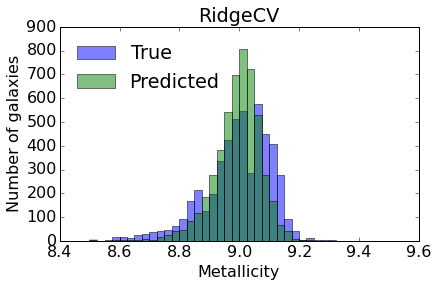

Estimator: Random Forests
Progress...
CV  0 ...
CV  1 ...
CV  2 ...


KeyboardInterrupt: 

In [17]:
#Compare different estimators

from matplotlib import rcParams

rcParams.update({'font.size': 16})

estimator_names = ['RidgeCV', 'Random Forests', 'Extra Random Trees', 'AdaBoost', 'SVM with rbf kernel']

estimators = [linear_model.RidgeCV(),RFbest1,ETbest1,Adabest1,SVRbest1]

for i, estimator in enumerate(estimators):
    
    print 'Estimator:', estimator_names[i]
    
    start = timeit.default_timer()
    
    refmetallicities, OLF, RMSE, RMSENOOL, R2_SCORE = predict_with_cv(X, y, z, m, e, l, elineslabels, bands, estimators[i],olthreshold=0.2,cv=5)    
    
    stop = timeit.default_timer()
    
    print 'Time to fit', stop - start
    
    plt.title(estimator_names[i])
    plt.tight_layout()
    plt.hist(y_test,alpha=0.5,label='True',range=[8.5,9.5],bins=40)
    plt.hist(refmetallicities,label = 'Predicted', alpha=0.5,range=[8.5,9.5],bins=40)
    plt.xlabel('Metallicity')
    if i == 0:
        plt.ylabel('Number of galaxies')
        plt.legend(loc = 'upper left', frameon = False)
#    plt.savefig(estimator_names[i]+'_bm.pdf')
    plt.show()
    
    

In [18]:
#Moving on to test set # 2
X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(2, mets, mags, errmags, red, red_err, mass = mass, err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass)
X_train, y_train, X_test, y_test, labels = build_train_test(X, y, z, m, e, l, elineslabels, bands, traintestsplit=.2)

Creating data set with 3050 objects


In [480]:
#optimizing ET regressor
parameters = {'n_estimators':[10, 50, 100], 'min_samples_split':[2, 4, 6,8], 'min_samples_leaf':[2,4,6,8]}
ncv=3
clf = GridSearchCV(ExtraTreesRegressor(),parameters,cv=ncv,scoring = loss,verbose=2)
clf.fit(X_train,y_train)

ETbest2 = clf.best_estimator_
ETbestscore2 = clf.best_score_

print ETbest2, ETbestscore2

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] min_samples_split=2, n_estimators=10, min_samples_leaf=2 ........
[CV]  min_samples_split=2, n_estimators=10, min_samples_leaf=2 -   0.1s
[CV] min_samples_split=2, n_estimators=10, min_samples_leaf=2 ........
[CV]  min_samples_split=2, n_estimators=10, min_samples_leaf=2 -   0.1s
[CV] min_samples_split=2, n_estimators=10, min_samples_leaf=2 ........
[CV]  min_samples_split=2, n_estimators=10, min_samples_leaf=2 -   0.1s
[CV] min_samples_split=2, n_estimators=50, min_samples_leaf=2 ........
[CV]  min_samples_split=2, n_estimators=50, min_samples_leaf=2 -   0.8s
[CV] min_samples_split=2, n_estimators=50, min_samples_leaf=2 ........
[CV]  min_samples_split=2, n_estimators=50, min_samples_leaf=2 -   0.7s
[CV] min_samples_split=2, n_estimators=50, min_samples_leaf=2 ........
[CV]  min_samples_split=2, n_estimators=50, min_samples_leaf=2 -   0.6s
[CV] min_samples_split=2, n_estimators=100, min_samples_leaf=2 .......
[CV]  min

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:   23.7s



[CV] min_samples_split=2, n_estimators=50, min_samples_leaf=4 ........
[CV]  min_samples_split=2, n_estimators=50, min_samples_leaf=4 -   0.4s
[CV] min_samples_split=2, n_estimators=100, min_samples_leaf=4 .......
[CV]  min_samples_split=2, n_estimators=100, min_samples_leaf=4 -   0.9s
[CV] min_samples_split=2, n_estimators=100, min_samples_leaf=4 .......
[CV]  min_samples_split=2, n_estimators=100, min_samples_leaf=4 -   0.9s
[CV] min_samples_split=2, n_estimators=100, min_samples_leaf=4 .......
[CV]  min_samples_split=2, n_estimators=100, min_samples_leaf=4 -   0.8s
[CV] min_samples_split=4, n_estimators=10, min_samples_leaf=4 ........
[CV]  min_samples_split=4, n_estimators=10, min_samples_leaf=4 -   0.1s
[CV] min_samples_split=4, n_estimators=10, min_samples_leaf=4 ........
[CV]  min_samples_split=4, n_estimators=10, min_samples_leaf=4 -   0.1s
[CV] min_samples_split=4, n_estimators=10, min_samples_leaf=4 ........
[CV]  min_samples_split=4, n_estimators=10, min_samples_leaf=4 -   

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  1.1min finished


In [481]:
parameters = {'n_estimators':[10, 20, 40], 'min_samples_split':[2, 4, 6,8], 'min_samples_leaf':[2,4,6,8]}
clf = GridSearchCV(RandomForestRegressor(),parameters,cv=ncv,scoring = loss,verbose=2)
clf.fit(X_train,y_train)

RFbest2 = clf.best_estimator_
RFbestscore2 = clf.best_score_

print RFbest2, RFbestscore2

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] min_samples_split=2, n_estimators=10, min_samples_leaf=2 ........
[CV]  min_samples_split=2, n_estimators=10, min_samples_leaf=2 -   0.5s
[CV] min_samples_split=2, n_estimators=10, min_samples_leaf=2 ........
[CV]  min_samples_split=2, n_estimators=10, min_samples_leaf=2 -   0.5s
[CV] min_samples_split=2, n_estimators=10, min_samples_leaf=2 ........
[CV]  min_samples_split=2, n_estimators=10, min_samples_leaf=2 -   0.5s
[CV] min_samples_split=2, n_estimators=20, min_samples_leaf=2 ........
[CV]  min_samples_split=2, n_estimators=20, min_samples_leaf=2 -   1.1s
[CV] min_samples_split=2, n_estimators=20, min_samples_leaf=2 ........
[CV]  min_samples_split=2, n_estimators=20, min_samples_leaf=2 -   1.0s
[CV] min_samples_split=2, n_estimators=20, min_samples_leaf=2 ........
[CV]  min_samples_split=2, n_estimators=20, min_samples_leaf=2 -   1.0s
[CV] min_samples_split=2, n_estimators=40, min_samples_leaf=2 ........
[CV]  min

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:   46.5s



[CV] min_samples_split=2, n_estimators=20, min_samples_leaf=4 ........
[CV]  min_samples_split=2, n_estimators=20, min_samples_leaf=4 -   0.7s
[CV] min_samples_split=2, n_estimators=40, min_samples_leaf=4 ........
[CV]  min_samples_split=2, n_estimators=40, min_samples_leaf=4 -   1.7s
[CV] min_samples_split=2, n_estimators=40, min_samples_leaf=4 ........
[CV]  min_samples_split=2, n_estimators=40, min_samples_leaf=4 -   1.7s
[CV] min_samples_split=2, n_estimators=40, min_samples_leaf=4 ........
[CV]  min_samples_split=2, n_estimators=40, min_samples_leaf=4 -   1.5s
[CV] min_samples_split=4, n_estimators=10, min_samples_leaf=4 ........
[CV]  min_samples_split=4, n_estimators=10, min_samples_leaf=4 -   0.4s
[CV] min_samples_split=4, n_estimators=10, min_samples_leaf=4 ........
[CV]  min_samples_split=4, n_estimators=10, min_samples_leaf=4 -   0.4s
[CV] min_samples_split=4, n_estimators=10, min_samples_leaf=4 ........
[CV]  min_samples_split=4, n_estimators=10, min_samples_leaf=4 -   0.4

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  2.3min finished


In [484]:
parameters = {'n_estimators':[10, 50, 100], 'loss' : ['exponential','square', 'linear']}

clf = GridSearchCV(AdaBoostRegressor(DecisionTreeRegressor(max_depth=8)),parameters,cv=ncv,scoring = loss,verbose=2)
clf.fit(X_train,y_train)

Adabest2 = clf.best_estimator_
Adabestscore2 = clf.best_score_

print Adabest2, Adabestscore2

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] n_estimators=10, loss=exponential ...............................
[CV] ...................... n_estimators=10, loss=exponential -   0.4s
[CV] n_estimators=10, loss=exponential ...............................
[CV] ...................... n_estimators=10, loss=exponential -   0.3s
[CV] n_estimators=10, loss=exponential ...............................
[CV] ...................... n_estimators=10, loss=exponential -   0.3s
[CV] n_estimators=50, loss=exponential ...............................
[CV] ...................... n_estimators=50, loss=exponential -   1.4s
[CV] n_estimators=50, loss=exponential ...............................
[CV] ...................... n_estimators=50, loss=exponential -   1.4s
[CV] n_estimators=50, loss=exponential ...............................
[CV] ...................... n_estimators=50, loss=exponential -   1.5s
[CV] n_estimators=100, loss=exponential ..............................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   38.4s finished



AdaBoostRegressor(base_estimator=DecisionTreeRegressor(compute_importances=None, criterion='mse', max_depth=8,
           max_features=None, max_leaf_nodes=None, min_density=None,
           min_samples_leaf=1, min_samples_split=2, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='exponential', n_estimators=50,
         random_state=None) -0.0921262387759


In [485]:
#optimizing SVR; rbf kernel is superior

parameters = {'C':[1, 10, 100], 'gamma':[0.01, 0.1, 0.5]}
clf = GridSearchCV(SVR(kernel='rbf'), parameters,cv=ncv,scoring = loss,verbose=2)
clf.fit(X_train,y_train)

SVRbest2 = clf.best_estimator_
SVRbestscore2 = clf.best_score_

print SVRbest2, SVRbestscore2

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] C=1, gamma=0.01 .................................................
[CV] ........................................ C=1, gamma=0.01 -   0.1s
[CV] C=1, gamma=0.01 .................................................
[CV] ........................................ C=1, gamma=0.01 -   0.1s
[CV] C=1, gamma=0.01 .................................................
[CV] ........................................ C=1, gamma=0.01 -   0.1s
[CV] C=1, gamma=0.1 ..................................................
[CV] ......................................... C=1, gamma=0.1 -   0.1s
[CV] C=1, gamma=0.1 ..................................................
[CV] ......................................... C=1, gamma=0.1 -   0.2s
[CV] C=1, gamma=0.1 ..................................................
[CV] ......................................... C=1, gamma=0.1 -   0.2s
[CV] C=1, gamma=0.5 ..................................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   15.1s finished



SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False) -0.0927604244891


In [19]:
#summary of test set 2

ETbest2 = ExtraTreesRegressor(bootstrap=False,
          criterion='mse', max_depth=None, max_features='auto',
          max_leaf_nodes=None, min_samples_leaf=4,
          min_samples_split=4, n_estimators=50, n_jobs=1, oob_score=False,
          random_state=None, verbose=0)

RFbest2 = RandomForestRegressor(bootstrap=True, 
           criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_samples_leaf=4,
           min_samples_split=4, n_estimators=40, n_jobs=1, oob_score=False,
           random_state=None, verbose=0)

Adabest2 = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=8,
           max_features=None, max_leaf_nodes=None, 
           min_samples_leaf=1, min_samples_split=2, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='exponential', n_estimators=50,
         random_state=None)

SVRbest2 = SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, 
  shrinking=True, tol=0.001, verbose=False)

Estimator: RidgeCV
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.0468852459016 pm 0.00573536251952 0.225228099219 pm 0.102628319054 0.0734365173042 pm 0.00229331157685 0.702602278442 pm 0.0261467118942
Time to fit 0.0556519031525


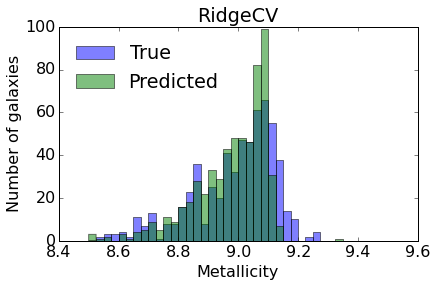

Estimator: Random Forests
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...


KeyboardInterrupt: 

In [20]:
#Compare different estimators

from matplotlib import rcParams

rcParams.update({'font.size': 16})

estimator_names = ['RidgeCV', 'Random Forests', 'Extra Random Trees', 'AdaBoost', 'SVM with rbf kernel']

estimators = [linear_model.RidgeCV(),RFbest2,ETbest2,Adabest2,SVRbest2]

for i, estimator in enumerate(estimators):
    
    print 'Estimator:', estimator_names[i]
    
    start = timeit.default_timer()
    
    refmetallicities, OLF, RMSE, RMSENOOL, R2_SCORE = predict_with_cv(X, y, z, m, e, l, elineslabels,bands, estimators[i],olthreshold=0.2,cv=5)    
    
    stop = timeit.default_timer()
    
    print 'Time to fit', stop - start
    
    plt.title(estimator_names[i])
    plt.tight_layout()
    plt.hist(y_test,alpha=0.5,label='True',range=[8.5,9.5],bins=40)
    plt.hist(refmetallicities,label = 'Predicted', alpha=0.5,range=[8.5,9.5],bins=40)
    plt.xlabel('Metallicity')
    if i == 0:
        plt.ylabel('Number of galaxies')
        plt.legend(loc = 'upper left', frameon = False)
#    plt.savefig(estimator_names[i]+'_2_bm.pdf')
    plt.show()

In [22]:
#Compare to RidgeCV for Table 2 -  test set 1

X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(1, mets, mags, errmags, red, red_err, mass = mass, err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass)

estimators = [linear_model.RidgeCV(),RFbest1,ETbest1,Adabest1,SVRbest1]

for i, estimator in enumerate(estimators):
    
    print 'Estimator:', estimator_names[i]
    
    start = timeit.default_timer()
    
    refmetallicities, OLF, RMSE, RMSENOOL, R2_SCORE = predict_with_cv(X, y, z, m, e, l,elineslabels,bands,estimators[i],olthreshold=0.2,cv=5)    
    
    stop = timeit.default_timer()
    
    print 'Time to fit', stop - start
    
    if estimator_names[i] == 'RidgeCV':
        
        refOLF, REFRMSE, REFRMSENOOL, REFR2_SCORE = OLF, RMSE, RMSENOOL, R2_SCORE         
        
        reftime = stop - start
    
    else:
        
        print 'ratios OLF, RMSE, RMSENOOL, R2, time', OLF/refOLF, RMSE/REFRMSE, RMSENOOL/REFRMSENOOL, R2_SCORE/REFR2_SCORE, (stop-start)/reftime 


Creating data set with 25316 objects
Estimator: RidgeCV
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.0248864309698 pm 0.00259635421294 0.0847942715786 pm 0.00166374764013 0.0706668844876 pm 0.000767822201049 0.557620939637 pm 0.0120767134906
Time to fit 0.47603392601
Estimator: Random Forests
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.021686746988 pm 0.0024138441426 0.0801772004682 pm 0.00128499658701 0.068587251345 pm 0.000415616401745 0.586076491881 pm 0.00811975976648
Time to fit 118.706825018
ratios OLF, RMSE, RMSENOOL, R2, time 0.871428571429 0.945549728485 0.970571319824 1.05103027921 249.366313054
Estimator: Extra Random Trees
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.0209757061031 pm 0.00122010232759 0.0792549325612 pm 0.00154816070427 0.0683479239816 pm 0.000731516261554 0.599610981476 pm 0.0

In [25]:
#Compare to RidgeCV for Table 2 -  test set 2

X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(2, mets, mags, errmags, red, red_err, mass = mass, err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass)

#X_train, y_train, X_test, y_test, labels = build_train_test(X, y, z, m, e, l, elineslabels)

estimators = [linear_model.RidgeCV(),RFbest2,ETbest2,Adabest2,SVRbest2]

for i, estimator in enumerate(estimators):
    
    print 'Estimator:', estimator_names[i]
    
    start = timeit.default_timer()
    
    refmetallicities, OLF, RMSE, RMSENOOL, R2_SCORE = predict_with_cv(X, y, z, m, e, l,elineslabels,bands,estimators[i],olthreshold=0.2,cv=5)    
    
    stop = timeit.default_timer()
    
    print 'Time to fit', stop - start
    
    if estimator_names[i] == 'RidgeCV':
        
        refOLF, REFRMSE, REFRMSENOOL, REFR2_SCORE = OLF, RMSE, RMSENOOL, R2_SCORE         
        
        reftime = stop - start
    
    else:
        
        print 'ratios OLF, RMSE, RMSENOOL, R2, time', OLF/refOLF, RMSE/REFRMSE, RMSENOOL/REFRMSENOOL, R2_SCORE/REFR2_SCORE, (stop-start)/reftime 


Creating data set with 3050 objects
Estimator: RidgeCV
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.044262295082 pm 0.0105224960891 0.139767498626 pm 0.0725450546169 0.0737629024906 pm 0.00137975503878 0.689169841472 pm 0.0127415768613
Time to fit 0.0522971153259
Estimator: Random Forests
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.0340983606557 pm 0.0054271951991 0.0877519391032 pm 0.000890009879309 0.0688216290027 pm 0.00215933179068 0.751592741253 pm 0.0160270550943
Time to fit 10.5593400002
ratios OLF, RMSE, RMSENOOL, R2, time 0.77037037037 0.627842237757 0.933011401109 1.09057694638 201.910563027
Estimator: Extra Random Trees
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.036393442623 pm 0.00580985086776 0.0881216754978 pm 0.00399179833872 0.0694940353515 pm 0.00286775080228 0.750282822378 pm 0.0151133

In [26]:
X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(1, mets, mags, errmags, red, red_err, mass = mass, err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass)
X_train, y_train, X_test, y_test, labels = build_train_test(X, y, z, m, e, l, elineslabels, bands,traintestsplit=.2)

Creating data set with 25316 objects


Indices 27
Feature ranking:
1. feature 25 Mass (0.198023)
2. feature 21 z - r (0.066916)
3. feature 19 z - g (0.065077)
4. feature 20 (z - g)$^2$ (0.063027)
5. feature 9 r - g (0.059275)
6. feature 22 (z - r)$^2$ (0.057762)
7. feature 13 i - g (0.050457)
8. feature 4 z (0.041453)
9. feature 2 r (0.040309)
10. feature 10 (r - g)$^2$ (0.038395)
11. feature 17 z - u (0.035243)
12. feature 14 (i - g)$^2$ (0.031643)
13. feature 3 i (0.030682)
14. feature 18 (z - u)$^2$ (0.027409)
15. feature 26 Redshift (0.025488)
16. feature 1 g (0.020011)
17. feature 5 g - u (0.017415)
18. feature 11 i - u (0.017337)
19. feature 6 (g - u)$^2$ (0.016461)
20. feature 0 u (0.016256)
21. feature 7 r - u (0.016054)
22. feature 12 (i - u)$^2$ (0.014064)
23. feature 23 z - i (0.011842)
24. feature 15 i - r (0.010519)
25. feature 24 (z - i)$^2$ (0.010473)
26. feature 16 (i - r)$^2$ (0.009952)
27. feature 8 (r - u)$^2$ (0.008459)
20


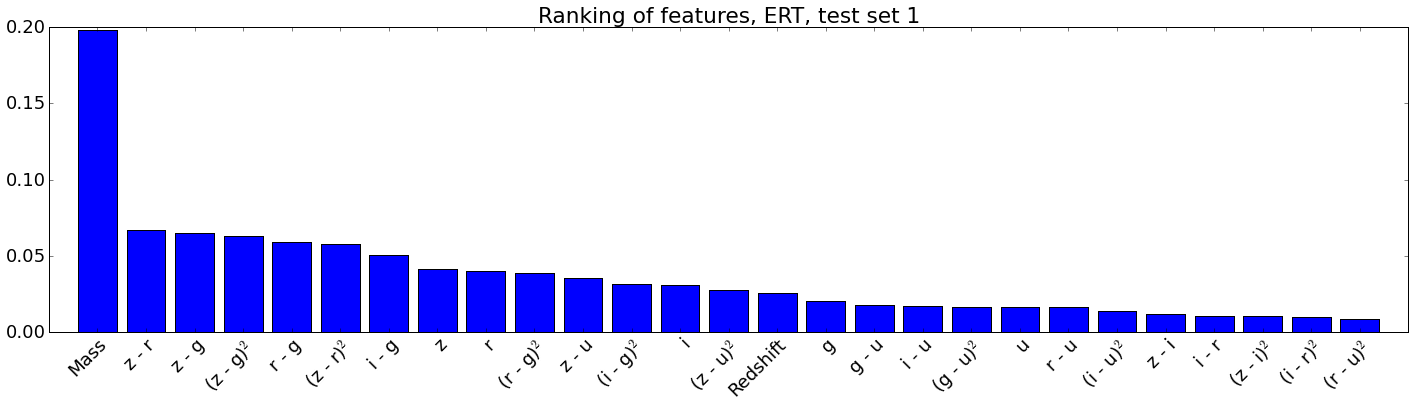

In [27]:
indicesET1 = FeatureRanking(labels,X_train,y_train,X_test,y_test,estimator=ETbest1,plot=True,plottitle='Ranking of features, ERT, test set 1',color='b',nmax=27)

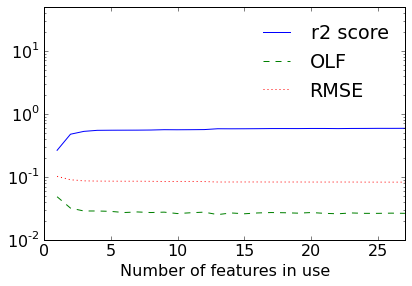

In [211]:
PerformanceFeatures(X_train.shape[1],indicesET1,labels,X_train,y_train,X_test,y_test,estimator = ETbest1,plottitle='Performance_ERT_testset1')

In [28]:
X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(2, mets, mags, errmags, red, red_err, mass = mass, err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass)
X_train, y_train, X_test, y_test, labels = build_train_test(X, y, z, m, e, l, elineslabels, bands,traintestsplit=.2)

Creating data set with 3050 objects


Indices 27
Feature ranking:
1. feature 25 Mass (0.212189)
2. feature 15 i - r (0.063340)
3. feature 13 i - g (0.062331)
4. feature 18 (z - u)$^2$ (0.050367)
5. feature 14 (i - g)$^2$ (0.050146)
6. feature 19 z - g (0.048267)
7. feature 9 r - g (0.047164)
8. feature 7 r - u (0.046526)
9. feature 17 z - u (0.044783)
10. feature 4 z (0.043364)
11. feature 21 z - r (0.042761)
12. feature 12 (i - u)$^2$ (0.030243)
13. feature 16 (i - r)$^2$ (0.028891)
14. feature 11 i - u (0.028716)
15. feature 3 i (0.025521)
16. feature 8 (r - u)$^2$ (0.024639)
17. feature 2 r (0.020545)
18. feature 20 (z - g)$^2$ (0.020369)
19. feature 23 z - i (0.016252)
20. feature 22 (z - r)$^2$ (0.015854)
21. feature 10 (r - g)$^2$ (0.015356)
22. feature 1 g (0.014673)
23. feature 26 Redshift (0.012727)
24. feature 0 u (0.012504)
25. feature 5 g - u (0.008066)
26. feature 6 (g - u)$^2$ (0.007352)
27. feature 24 (z - i)$^2$ (0.007054)
20


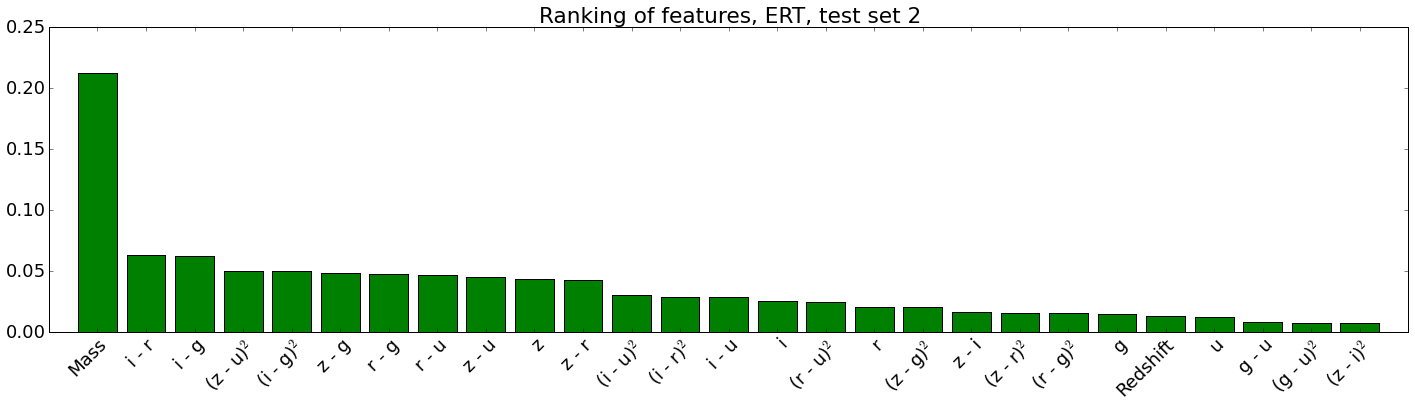

In [29]:
indicesET2 = FeatureRanking(labels,X_train,y_train,X_test,y_test,estimator=ETbest2,plot=True,plottitle='Ranking of features, ERT, test set 2',color='g',nmax=27)

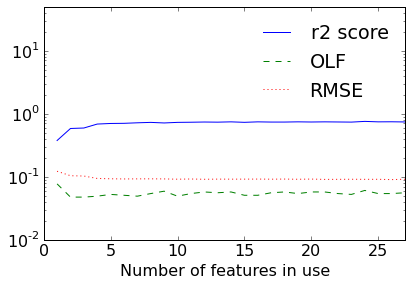

In [30]:
PerformanceFeatures(X_train.shape[1],indicesET2,labels,X_train,y_train,X_test,y_test,estimator = ETbest2,plottitle='Performance_ERT_testset2')

In [38]:
#build figure 3. Turn off shuffling to get exact values of paper.
X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(1, mets, mags, errmags, red, red_err, mass = mass,err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass, elines = [], elineslabels = [])
X_train, y_train, X_test, y_test, labels = build_train_test(X, y, z, m, e, l, elineslabels, bands,traintestsplit=.2)
set1_pred, set1_truth = prediction(X_train,y_train,X_test,y_test,ETbest1,olthreshold=0.2)[0], y_test

Creating data set with 25316 objects


In [40]:
X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(2, mets, mags, errmags, red, red_err, mass = mass,err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass, elines = [], elineslabels = [])
X_train, y_train, X_test, y_test, labels = build_train_test(X, y, z, m, e, l, elineslabels, bands,traintestsplit=.2)
set2_pred, set2_truth = prediction(X_train,y_train,X_test,y_test,ETbest2,olthreshold=0.2)[0], y_test

Creating data set with 3050 objects


<function matplotlib.pyplot.show>

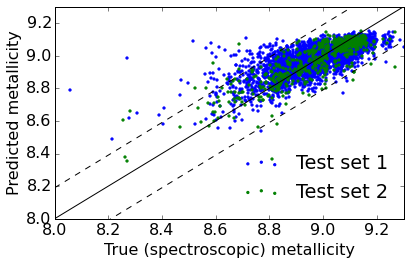

In [41]:
plt.axis([8.0,9.3,8.0,9.3],'equal')
plt.scatter(set1_truth, set1_pred, color = 'b', label = 'Test set 1', s = 5)
plt.scatter(set2_truth, set2_pred, color = 'g', label = 'Test set 2', s= 5)
plt.plot(np.arange(7.8,9.3,0.01),np.arange(7.8,9.3,0.01),'k')
plt.plot(np.arange(7.81,9.3,0.01),np.arange(8.0,9.5,0.01),'--k')
plt.plot(np.arange(7.81,9.3,0.01),np.arange(7.6,9.1,0.01),'--k')
plt.xlabel('True (spectroscopic) metallicity')
plt.ylabel('Predicted metallicity')

plt.legend(frameon=False, loc = 'lower right',numpoints=1)
plt.tight_layout()
#plt.savefig('BestResults.pdf')
plt.show

In [42]:
#prepare data to plot learning curves

X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(1, mets, mags, errmags, red, red_err, mass = mass,err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass, elines = [], elineslabels = [])
X_train_1, y_train_1, X_test_1, y_test_1, labels = build_train_test(X, y, z, m, e, l, elineslabels, bands, traintestsplit=.001)
X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(2, mets, mags, errmags, red, red_err, mass = mass,err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass, elines = [], elineslabels = [])
X_train_2, y_train_2, X_test_2, y_test_2, labels = build_train_test(X, y, z, m, e, l, elineslabels, bands, traintestsplit=.001)

Creating data set with 25316 objects
Creating data set with 3050 objects


[ 0.0832404   0.0820747   0.08147007  0.08095388  0.08050629  0.08026703] [ 0.00129671  0.00107027  0.00112568  0.00089129  0.00088033  0.00085566]
[ 0.09586148  0.09504713  0.09351112  0.09204713  0.09063496  0.0893238 ] [ 0.00501321  0.00429744  0.00504989  0.00544701  0.00622485  0.0054363 ]


<module 'matplotlib.pyplot' from '/Library/Python/2.7/site-packages/matplotlib/pyplot.pyc'>

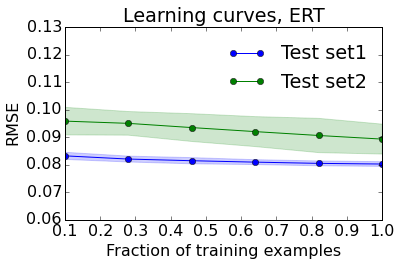

In [44]:
plot_multi_learning_curve([ETbest1,ETbest2], 'Learning curves, ERT', [X_train_1,X_train_2], y = [y_train_1,y_train_2], ylim = [0.06, 0.13], cv=6,
                        n_jobs=2,  scoring = loss)

In [45]:
#time to add some emission lines and see what happens! (use list of desired lines)# 

X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(1, mets, mags, errmags, red, red_err, mass = mass,err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass,elines = [OII,OIII,Halpha,Hbeta,NII], elineslabels = ['OII','OIII','Halpha','Hbeta','NII'])
y_pred, OLF, RMSE, RMSENOOL, R2_SCORE = predict_with_cv(X, y, z, m, e, l, elineslabels,bands, ETbest1,cv=5)


Creating data set with 25316 objects
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.00517479755086 pm 0.000904248322517 0.0474570805142 pm 0.00103115039163 0.0419332049041 pm 0.000454466580803 0.859052112592 pm 0.00484386838088


Indices 32
Feature ranking:
1. feature 30 Mass (0.145225)
2. feature 29 NII (0.143031)
3. feature 26 OIII (0.142073)
4. feature 25 OII (0.074722)
5. feature 20 (z - g)$^2$ (0.057990)
6. feature 19 z - g (0.041756)
7. feature 9 r - g (0.040727)
8. feature 28 Hbeta (0.035066)
9. feature 22 (z - r)$^2$ (0.033632)
10. feature 27 Halpha (0.032905)
11. feature 14 (i - g)$^2$ (0.028749)
12. feature 17 z - u (0.028543)
13. feature 21 z - r (0.028296)
14. feature 4 z (0.026277)
15. feature 13 i - g (0.024791)
16. feature 2 r (0.017388)
17. feature 10 (r - g)$^2$ (0.014517)
18. feature 3 i (0.013494)
19. feature 11 i - u (0.009844)
20. feature 18 (z - u)$^2$ (0.007979)
21. feature 8 (r - u)$^2$ (0.007590)
22. feature 7 r - u (0.006865)
23. feature 31 Redshift (0.006852)
24. feature 1 g (0.006836)
25. feature 0 u (0.005912)
26. feature 23 z - i (0.003879)
27. feature 12 (i - u)$^2$ (0.003542)
28. feature 15 i - r (0.002986)
29. feature 5 g - u (0.002525)
30. feature 6 (g - u)$^2$ (0.002317)
31. f

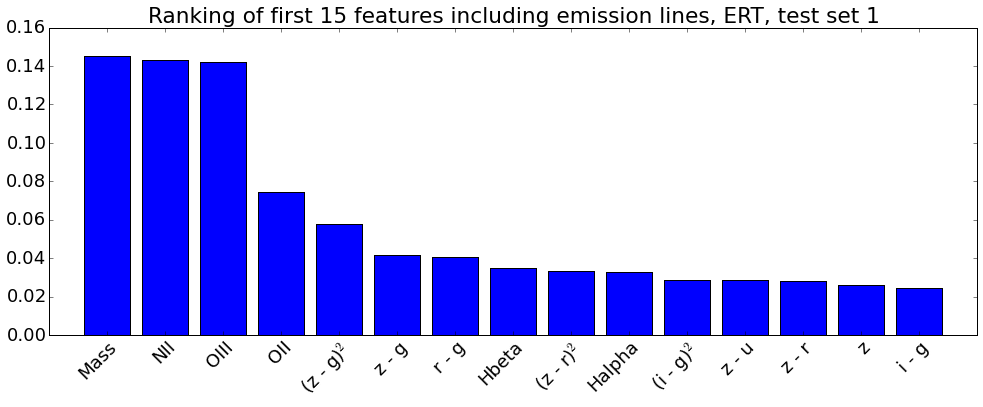

array([30, 29, 26, 25, 20, 19,  9, 28, 22, 27, 14, 17, 21,  4, 13,  2, 10,
        3, 11, 18,  8,  7, 31,  1,  0, 23, 12, 15,  5,  6, 16, 24])

In [48]:
#turn off shuffling to reproduce figure in paper
X_train, y_train, X_test, y_test, labels = build_train_test(X, y, z, m, e, l, elineslabels, bands,traintestsplit=.2)
FeatureRanking(labels,X_train,y_train,X_test,y_test,estimator=ETbest1,plot=True,plottitle='Ranking of first 15 features including emission lines, ERT, test set 1',nmax=15, color = 'b')

In [49]:
red_noerr = np.empty(len(red_err))
red_noerr.fill(1e-12)

In [50]:
#let's also add some emission lines with spec z (doesn't matter much)#

X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(1, mets, mags, errmags, red, red_noerr, mass = mass,err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass,elines = [NII], elineslabels = ['NII'])
y_pred, OLF, RMSE, RMSENOOL, R2_SCORE = predict_with_cv(X, y, z, m, e, l, elineslabels,bands, ETbest1,cv=5)


Creating data set with 25316 objects
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.0148133517677 pm 0.00150420168 0.0728975540639 pm 0.0011843496896 0.064413770808 pm 0.000508027748019 0.650187596133 pm 0.00925599682072


In [52]:
#add ELs one by one#
rankedlist = [NII, OIII, OII, Hbeta, Halpha]
rankedlabels = ['NII', 'OIII', 'OII', 'Hbeta', 'Halpha']
for i in range(len(rankedlist)):
    X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(1, mets, mags, errmags, red, red_err, mass = mass,err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass,elines = rankedlist[:i+1], elineslabels = rankedlabels[:i+1])
    y_pred, OLF, RMSE, RMSENOOL, R2_SCORE = predict_with_cv(X, y, z, m, e, l, elineslabels,bands,ETbest1,cv=5)


Creating data set with 25316 objects
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.0145763381394 pm 0.00116782504437 0.0733359375648 pm 0.000952322315281 0.0644234564454 pm 0.000339906442067 0.646134227309 pm 0.00624030852206
Creating data set with 25316 objects
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.0075449338337 pm 0.00104064308689 0.0545730779344 pm 0.00193568433912 0.0482212580635 pm 0.000317928644483 0.812813034487 pm 0.00335067422322
Creating data set with 25316 objects
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.00620185660675 pm 0.00160264371125 0.0494096438745 pm 0.00184062625916 0.0436105863719 pm 0.000552724488577 0.847719085181 pm 0.00479404901522
Creating data set with 25316 objects
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.

In [71]:
#trying out different stuff (set 1) -- this is used to get numbers in table 3. Need to adjust to each case
X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(1, mets, mags, errmags, red, red_err, mass = mass, err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass)
predict_with_cv(X, y, z, m, e, l, elineslabels, bands, ETbest1, olthreshold=0.2,cv=10, scaling=True)

Creating data set with 25316 objects
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
CV  5 ...
CV  6 ...
CV  7 ...
CV  8 ...
CV  9 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.0219237606162 pm 0.00200452134408 0.0810147234613 pm 0.00128705359439 0.0687290016588 pm 0.000633801740974 0.590074698988 pm 0.011022417015


(array([ 8.79524313,  9.05051148,  9.05666475, ...,  9.02162484,
         9.11157426,  9.00970892]),
 0.021923760616235431,
 0.08101472346133011,
 0.068729001658782859,
 0.59007469898828446)

Creating data set with 3050 objects
Indices 32
Feature ranking:
1. feature 25 OII (0.151388)
2. feature 30 Mass (0.112842)
3. feature 26 OIII (0.109867)
4. feature 29 NII (0.107803)
5. feature 14 (i - g)$^2$ (0.067876)
6. feature 11 i - u (0.039555)
7. feature 15 i - r (0.036395)
8. feature 3 i (0.033526)
9. feature 19 z - g (0.031760)
10. feature 13 i - g (0.030311)
11. feature 17 z - u (0.029418)
12. feature 4 z (0.029034)
13. feature 28 Hbeta (0.025716)
14. feature 18 (z - u)$^2$ (0.024232)
15. feature 27 Halpha (0.022005)
16. feature 9 r - g (0.020351)
17. feature 16 (i - r)$^2$ (0.019468)
18. feature 12 (i - u)$^2$ (0.014019)
19. feature 2 r (0.012731)
20. feature 21 z - r (0.011091)
21. feature 10 (r - g)$^2$ (0.009382)
22. feature 1 g (0.009108)
23. feature 5 g - u (0.008431)
24. feature 23 z - i (0.008333)
25. feature 24 (z - i)$^2$ (0.006951)
26. feature 8 (r - u)$^2$ (0.006008)
27. feature 0 u (0.004819)
28. feature 7 r - u (0.004262)
29. feature 20 (z - g)$^2$ (0.003527)
30.

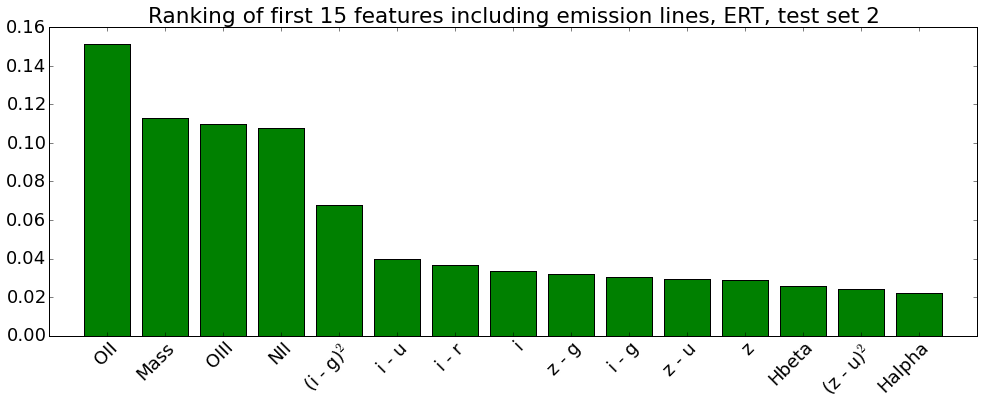

array([25, 30, 26, 29, 14, 11, 15,  3, 19, 13, 17,  4, 28, 18, 27,  9, 16,
       12,  2, 21, 10,  1,  5, 23, 24,  8,  0,  7, 20, 22, 31,  6])

In [53]:
#time to add some emission lines and see what happens!# Test set #2

X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(2, mets, mags, errmags, red, red_err, mass = mass,err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass,elines = [OII,OIII,Halpha,Hbeta,NII], elineslabels = ['OII','OIII','Halpha','Hbeta','NII'])
X_train, y_train, X_test, y_test, labels = build_train_test(X, y, z, m, e, l, elineslabels, bands, traintestsplit=.2)
FeatureRanking(labels,X_train,y_train,X_test,y_test,estimator=ETbest2,plot=True,plottitle='Ranking of first 15 features including emission lines, ERT, test set 2',nmax=15, color = 'g')

In [54]:
#let's also add some emission lines with spec z - test set 2 #

X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(2, mets, mags, errmags, red, red_noerr, mass = mass,err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass,elines = [OII,NII,OIII,Hbeta,Halpha], elineslabels = ['OII','NII','OIII','Hbeta','Halpha'])
y_pred, OLF, RMSE, RMSENOOL, R2_SCORE = predict_with_cv(X, y, z, m, e, l, elineslabels,bands, ETbest2,cv=5)


Creating data set with 3050 objects
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.0147540983607 pm 0.00146627408361 0.0602131190996 pm 0.00145735502731 0.0491974653093 pm 0.00107646226417 0.879333192427 pm 0.00851254247143


In [56]:
#add ELs one by one#
rankedlist = [OII, NII, OIII, Hbeta, Halpha]
rankedlabels = ['OII', 'NII', 'OIII', 'Hbeta', 'Halpha']
for i in range(len(rankedlist)):
    X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(2, mets, mags, errmags, red, red_err, mass = mass,err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass,elines = rankedlist[:i+1], elineslabels = rankedlabels[:i+1])
    y_pred, OLF, RMSE, RMSENOOL, R2_SCORE = predict_with_cv(X, y, z, m, e, l, elineslabels,bands,ETbest2,cv=5)


Creating data set with 3050 objects
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.0232786885246 pm 0.00869934371241 0.0809241255673 pm 0.00580933207787 0.0646051627576 pm 0.00102036458961 0.79713070173 pm 0.0154067698357
Creating data set with 3050 objects
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.0134426229508 pm 0.00393442622951 0.0620776419984 pm 0.00379658750084 0.051447452137 pm 0.00197919073037 0.866122257231 pm 0.00608282652265
Creating data set with 3050 objects
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.00918032786885 pm 0.00304053065426 0.0587536243041 pm 0.00410990775605 0.0513069481201 pm 0.00201774688697 0.867366482928 pm 0.00939012744609
Creating data set with 3050 objects
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.00885245901

In [72]:
#trying out different stuff (set 2) --- used for Table 3; need to adjust for each case
X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(2, mets, mags, errmags, red, red_err, mass = mass, err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass)
predict_with_cv(X, y, z, m, e, l, elineslabels, bands, ETbest1, olthreshold=0.2,cv=10, scaling=True)

Creating data set with 3050 objects
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
CV  5 ...
CV  6 ...
CV  7 ...
CV  8 ...
CV  9 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.0416393442623 pm 0.00503681688385 0.0930606044565 pm 0.00406544690675 0.0706713659653 pm 0.00168406514029 0.728277252889 pm 0.0242392347652


(array([ 9.09049982,  8.979271  ,  8.89041264,  8.9550154 ,  8.8618995 ,
         9.05670406,  9.07791099,  8.92510971,  9.06940158,  9.01876361,
         8.96515886,  9.03216688,  8.63637507,  8.67740124,  9.00484684,
         9.0916936 ,  8.92092546,  9.11563529,  9.06409552,  9.09015373,
         9.09789522,  9.09872487,  8.97215396,  9.08832173,  9.02570838,
         8.86790514,  9.11543245,  9.07384853,  8.84333175,  9.05415991,
         8.98076401,  9.00472128,  8.9704801 ,  8.58957375,  9.01934818,
         8.64407481,  9.06543525,  9.04142847,  9.07649015,  8.95693551,
         8.86126976,  9.05112735,  9.08529207,  8.8647938 ,  9.085177  ,
         9.02122121,  9.08157147,  9.04105186,  8.87554167,  8.95781365,
         9.09290028,  9.08753216,  9.08468547,  9.10897763,  8.9037688 ,
         8.85906091,  9.01584786,  8.88436209,  8.98205364,  8.93836446,
         9.09240038,  9.0881388 ,  9.09772455,  8.7627849 ,  9.07345384,
         9.07233063,  8.98966561,  9.04203773,  8.8

In [71]:
#Get result for Sanders's sample

X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(3, mets, mags, errmags, red, red_err, mass = mass, err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass, find=[indexes_sanders])
y_pred, OLF, RMSE, RMSENOOL, R2_SCORE = predict_with_cv(X, y, z, m, e, l, elineslabels, bands, ETbest1, olthreshold=0.2,cv=5)

Creating data set with 113805 objects
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.0484249373929 pm 0.00124960336257 0.0979235558051 pm 0.000511848585512 0.078054009587 pm 0.000211643840353 0.788913252203 pm 0.00200197609328


In [59]:
#Analyze results in "Sanders" slice
for i in range(8):
    minred = 0.03+i*0.03
    maxred = 0.03+(i+1)*0.03
    print 'Slice', i, 'redshift values', minred, maxred  
    findred = np.where(np.logical_and(red > minred, red < maxred))
    find_sanders_slice = list(set(list(findred[0])).intersection(list(indexes_sanders)))
    X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(3, mets, mags, errmags, red, red_err, mass = mass, err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass, find = [find_sanders_slice])
    y_pred, OLF, RMSE, RMSENOOL, R2_SCORE = predict_with_cv(X, y, z, m, e, l, elineslabels, bands, ETbest1, olthreshold=0.2,cv=5)


Slice 0 redshift values 0.03 0.06
Creating data set with 41210 objects
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.0843727250667 pm 0.00273635629391 0.116988785456 pm 0.000853729902905 0.0888542390504 pm 0.000259264895471 0.798181626581 pm 0.00295836575766
Slice 1 redshift values 0.06 0.09
Creating data set with 40336 objects
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.0348084789885 pm 0.00186915352175 0.0911480572552 pm 0.000607560996678 0.076672746184 pm 0.000366456609076 0.672902516562 pm 0.00334671499811
Slice 2 redshift values 0.09 0.12
Creating data set with 18709 objects
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.0189254210104 pm 0.00268588221055 0.0778551388136 pm 0.00310753573164 0.0675254315816 pm 0.00063832771403 0.557100433041 pm 0.00723487003881
Slice 3 redshift values 0.12 0.15
Creating d

In [60]:
#these depend slightly on random seed.

OLF_slices = [0.083, 0.036, 0.021, 0.016, 0.017, 0.012, 0.015, 0.075]
RMSE_slices = [0.12, 0.092, 0.079, 0.071, 0.070, 0.066, 0.059, 0.13]
RMSE_slices_noOL = [0.089, 0.077, 0.067, 0.062, 0.060, 0.060, 0.052, 0.07]
nobj_slices = [41210, 40336, 18709, 9324, 2716, 1078, 331, 80]
med_red_slices = [0.045+i*0.03 for i in range(8)]

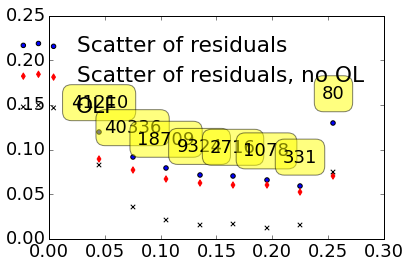

In [61]:
plt.scatter(med_red_slices,RMSE_slices, label = 'Scatter of residuals')
plt.scatter(med_red_slices,RMSE_slices_noOL, label = 'Scatter of residuals, no OL', marker = 'd', color = 'r')
plt.scatter(med_red_slices,OLF_slices, marker='x', label ='OLF', color='k')
labels = [str(el) for el in nobj_slices]
for label, x, y in zip(labels, med_red_slices, RMSE_slices):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (0, 20),
        textcoords = 'offset points', ha = 'center', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))#,#,
#        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.legend(loc='best',frameon=False,numpoints=1)
plt.xlim(0.0,0.3)
plt.ylim(0,0.25)
#plt.savefig('Slices.pdf')
plt.show()

In [62]:
#Cumulative results in "Sanders" slice (no Emission Lines cut)
minred = 0.03
maxred = 0.3
find_sanders_light = np.where(np.logical_and(True, np.logical_and(mass > 0., np.logical_and(spectrotype == 'GALAXY', np.logical_and(subclass != 'AGN',np.logical_and(mags[:,2] < 17.77, np.logical_and(red > 0.03,np.logical_and(red < 0.3,np.logical_and(np.logical_and(mets > 0.0, red_warn == 0), np.all(abs(mags[:,0:mags.shape[1]]) > 0.01, axis = 1))))))))))
X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(3, mets, mags, errmags, red, red_err, mass = mass, err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass, find = find_sanders_light)
y_pred, OLF, RMSE, RMSENOOL, R2_SCORE = predict_with_cv(X, y, z, m, e, l, elineslabels, bands, ETbest1, olthreshold=0.2,cv=5)


Creating data set with 132161 objects
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.0457778450363 pm 0.00128342324536 0.0963243303646 pm 0.000804218797759 0.0768622073276 pm 0.000131095020071 0.799603270421 pm 0.00227514142439


In [72]:
# Test set 1
#calculate uncertainties from photometry only using SDSS limiting mags
X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(1, mets, mags, errmags, red, red_err, mass = mass, err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass)
Exp_error = calculate_uncertainties(X, y, z, m, e, l, z_e, m_e, ETbest1, ntrials = 50)


Creating data set with 25316 objects
Average scatter 0.0128601810729


In [75]:
limmagLSST = [26.3, 27.5, 27.7, 27.0, 26.2, 24.9]

In [50]:
#calculate uncertainties from photometry only using LSST limiting mags

errLSST_1 = np.empty(mags.shape)
for i in range(mags.shape[1]):
    errLSST_1[:,i] = 10**((mags[:,i] - (limmagLSST[i] + 1.75))/2.5)*1.085

X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(1, mets, mags, errLSST_1, red, red_err, mass = mass, err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass)
Exp_error = calculate_uncertainties(X, y, z, m, e, l, z_e, m_e, ETbest1, ntrials = 50)

In [183]:
errperfect_1 = np.empty(mags.shape)
errperfect_1.fill(1e-12)

In [186]:
#calculate uncertainties using perfect (zero photo-err)
X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(1, mets, mags, errperfect_1, red, red_err, mass = mass, err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass)
Exp_error = calculate_uncertainties(X, y, z, m, e, l, z_e, m_e, ETbest1, ntrials = 50)
#Average scatter 0.0227187918976

Creating data set with 25316 objects
Average scatter 0.00425641007563


In [73]:
# Test set 2
#calculate uncertainties using SDSS limiting mags
X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(2, mets, mags, errmags, red, red_err, mass = mass, err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass)
Exp_error = calculate_uncertainties(X, y, z, m, e, l, z_e, m_e, ETbest2, ntrials = 50)


Creating data set with 3050 objects
Average scatter 0.0182877582397


In [76]:
#calculate uncertainties from photometry only using LSST limiting mags

errLSST_2 = np.empty(mags.shape)
for i in range(mags.shape[1]):
    errLSST_2[:,i] = 10**((mags[:,i] - (limmagLSST[i] + 1.75))/2.5)*1.085
    
X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(2, mets, mags, errLSST_2, red, red_err, mass = mass, err_mass=(mass_hi-mass_lo)/2.,spectrotype=spectrotype, subclass=subclass)
Exp_error = calculate_uncertainties(X, y, z, m, e, l, z_e, m_e, ETbest2, ntrials = 50)

Creating data set with 3050 objects
Average scatter 0.00828196959396


In [77]:
#calculate uncertainties using perfect photometry 
errperfect_2 = np.empty(mags.shape)
errperfect_2.fill(1e-12)
X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(2, mets, mags, errperfect_2, red, red_err, mass = mass, err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass)
Exp_error = calculate_uncertainties(X, y, z, m, e, l, z_e, m_e, ETbest2, ntrials = 50)



Creating data set with 3050 objects
Average scatter 0.00804889677876


In [78]:
#Use mocks to find improvement between 5 and 6 bands. Note: unrealistic bc mass-metallicity relation is not implemented & there is too little scatter

mags = np.loadtxt('Mocks/SDSS_sixbands_ts2.dat')

print mags.shape

#Let's only use five#

mags5 = mags[:,:mags.shape[1]-1]

stuff = np.loadtxt('Mocks/SDSS_sample_for_LSST_Params.dat',comments='#') #excluding the ones for which no fit was found

mets = stuff[:,1]

red = stuff[:,2]

mass = stuff[:,3]

errmags = np.ones(mags.shape)
errmags5 = np.ones(mags5.shape)
err_red = np.ones(red.shape)
err_mass = np.ones(mass.shape)
clf = ExtraTreesRegressor(bootstrap=False, 
          criterion='mse', max_depth=None, max_features='auto',
          max_leaf_nodes=None, min_samples_leaf=8,
          min_samples_split=2, n_estimators=100, n_jobs=1, oob_score=False,
          random_state=None, verbose=0)

X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(3, mets, mags, errmags, red, err_red, bands = ['u','g','r','i','z','y'], mass = mass, err_mass = err_mass,find=[])
y_pred, OLF, RMSE, RMSENOOL, R2_SCORE = predict_with_cv(X, y, z, m, e, l, elineslabels,bands,clf)

X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(3, mets, mags5, errmags5, red, err_red, bands = ['u','g','r','i','z'], mass = mass, err_mass = err_mass,find=[])
y_pred, OLF, RMSE, RMSENOOL, R2_SCORE = predict_with_cv(X, y, z, m, e, l, elineslabels,bands,clf)


(2907, 6)
Creating data set with 2907 objects
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
CV  5 ...
CV  6 ...
CV  7 ...
CV  8 ...
CV  9 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.0 pm 0.0 0.00420438872747 pm 0.000243056018364 0.00420438872747 pm 0.000243056018364 0.90059221318 pm 0.01086307218
Creating data set with 2907 objects
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
CV  5 ...
CV  6 ...
CV  7 ...
CV  8 ...
CV  9 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.0 pm 0.0 0.00457863116188 pm 0.000225049087631 0.00457863116188 pm 0.000225049087631 0.879834967205 pm 0.0121083428715


In [69]:
#Just an aside - this was used to find best value of alpha to report in Table 1
X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(2, mets, mags, errmags, red, red_err, mass = mass, err_mass=(mass_hi-mass_lo)/2,spectrotype=spectrotype, subclass=subclass)
X_train, y_train, X_test, y_test, labels = build_train_test(X, y, z, m, e, l, elineslabels, bands, traintestsplit=.2)
clf = linear_model.RidgeCV()
print clf.get_params(deep=True)
clf.fit(X_train, y_train)
clf.alpha_

Creating data set with 3050 objects
{'normalize': False, 'alphas': array([  0.1,   1. ,  10. ]), 'fit_intercept': True, 'gcv_mode': None, 'store_cv_values': False, 'scoring': None, 'cv': None}


0.10000000000000001

In [768]:
#This is how Mocks for SED fitting were generated

#Create catalog of test set 2

lam = [3543.,4770.,6231.,7625.,9134]
outfile = open('SDSS_ts2_mets_red_mass.txt','w')
zfile = open('SDSS_ts2_redshifts.txt','w')

X, y, z, m, e, z_e, m_e, l, elineslabels = makedataset(2, mets, mags, errmags, red, red_err, mass = mass,elines = [], elineslabels = [])

for i in range(X.shape[0]):
    file = open('SDSS_ts2_'+str(i+1)+'.dat','w')
    for j in range(mags.shape[1]):
        flux = 10**((23.9-float(mags[i,j]))/5.)
        file.write(('%.3f \t %.3f \t %.3f \n') % (lam[j], flux, flux*float(errmags[i,j])))
    file.close()
    outfile.write("%s \t %s \t %s \t %s \n" % (i+1, y[i], z[i], m[i]))
    zfile.write("%s \t %s \n" % (str(i+1),z[i]))
zfile.close()
outfile.close()